In [21]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 데이터 로딩
df = pd.read_csv('C:/Users/wjdqh/injige/diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Epoch 1/30, Loss: 88.9660, Accuracy: 0.6987
Epoch 2/30, Loss: 71.8757, Accuracy: 0.7801
Epoch 3/30, Loss: 68.5159, Accuracy: 0.7720
Epoch 4/30, Loss: 67.3429, Accuracy: 0.7818
Epoch 5/30, Loss: 66.3414, Accuracy: 0.7801
Epoch 6/30, Loss: 64.8607, Accuracy: 0.7850
Epoch 7/30, Loss: 64.5077, Accuracy: 0.7948
Epoch 8/30, Loss: 63.5273, Accuracy: 0.8078
Epoch 9/30, Loss: 63.1095, Accuracy: 0.8062
Epoch 10/30, Loss: 62.5110, Accuracy: 0.8078
Epoch 11/30, Loss: 61.6620, Accuracy: 0.8046
Epoch 12/30, Loss: 61.5185, Accuracy: 0.8046
Epoch 13/30, Loss: 60.4208, Accuracy: 0.8143
Epoch 14/30, Loss: 59.6639, Accuracy: 0.8208
Epoch 15/30, Loss: 58.7954, Accuracy: 0.8306
Epoch 16/30, Loss: 58.6611, Accuracy: 0.8274
Epoch 17/30, Loss: 58.0827, Accuracy: 0.8306
Epoch 18/30, Loss: 57.1144, Accuracy: 0.8306
Epoch 19/30, Loss: 56.4853, Accuracy: 0.8371
Epoch 20/30, Loss: 55.7375, Accuracy: 0.8420
Epoch 21/30, Loss: 55.2273, Accuracy: 0.8453
Epoch 22/30, Loss: 54.3419, Accuracy: 0.8453
Epoch 23/30, Loss: 

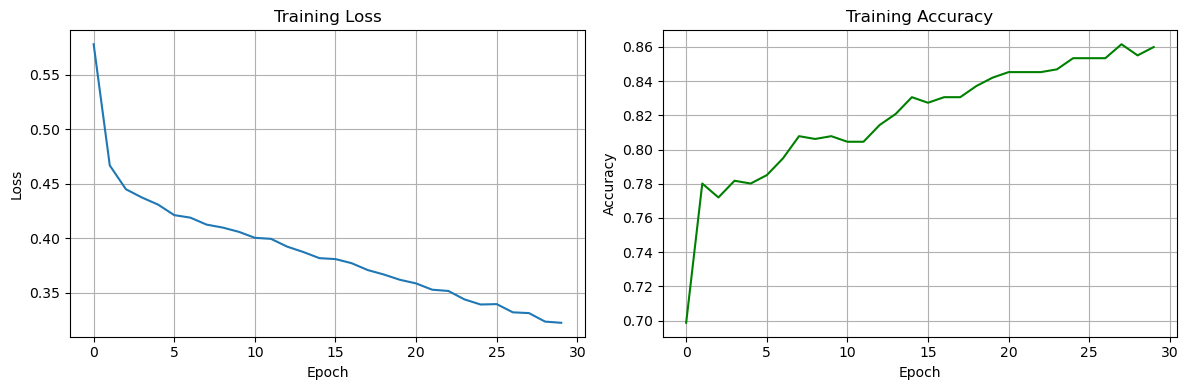

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

# --- 데이터 준비 ---
df = pd.read_csv('diabetes.csv')  # diabetes.csv 파일 읽기

columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

label_encoders = {}
for column in columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])


# 분류용 데이터 준비
X = df.drop(['Outcome'], axis=1).values
y = df['Outcome'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)    

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# --- 딥러닝 모델 정의 ---
class DiabetesClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(X.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = DiabetesClassifier()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- 학습 ---
num_epochs = 30
loss_history = []
acc_history = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        outputs = outputs.squeeze()  # 차원 축소
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predicted = (outputs.detach().numpy() > 0.5).astype(int)
        correct += (predicted == batch_y.numpy()).sum()
        total += batch_y.size(0)

    acc = correct / total
    loss_history.append(total_loss / len(train_loader))
    acc_history.append(acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")

# --- 평가 ---
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    outputs = outputs.squeeze() # Test 데이터도 squeeze 적용
    y_pred = (outputs > 0.5).int()

f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print(f"\nTest Accuracy: {acc:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# --- 시각화 ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(acc_history, label='Accuracy', color='green')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


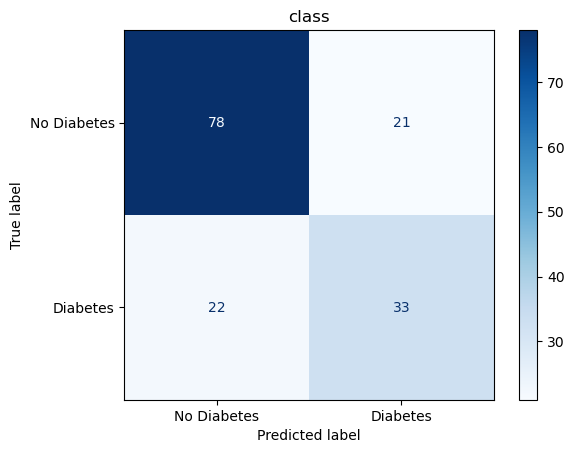

In [22]:
    # Confusion Matrix
    cm = confusion_matrix(y_test, pred2)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Diabetes", "Diabetes"])
    disp.plot(cmap='Blues')
    plt.title("class")
    plt.show()